In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
from collections import Counter
from wordcloud import WordCloud
from lib.training_preparation import count_distinct_words
from lib.training_preparation import limit_by_type


tqdm.pandas()

# MEAN COUNT OF DISTINCT WORDS

In [2]:
dset_path = 'data/limit_5K_per_type_order_by_id_desc'
df_fpaths = [f'{dset_path}/00_chosen_types/chosen_types_df.csv', 
            f'{dset_path}/01_processed/cleaned.csv', 
            f'{dset_path}/01_processed/stemmed.csv', 
            f'{dset_path}/01_processed/lemmatized.csv']

min_count_of_words = 10
min_ratio = 0.1

In [3]:
results4stats = []

for e, in_path in enumerate(df_fpaths):
    print(f'Reading from {in_path}...')
    df = pd.read_csv(in_path, sep=';')
    df['text'] = df['text'].astype('str')

    print('Counting distinct words')
    df['codw'] = df['text'].progress_apply(count_distinct_words)

    print('Getting statistics...')
    df['count'] = df['codw'].apply(lambda x: len(x))
    
    ctype = 'type'
    if e == 0:
        ctype = 'id_typ_dokument_true'
    results4stats.append(df[[ctype, 'count']].groupby([ctype]).mean().copy())

Reading from data/limit_5K_per_type_order_by_id_desc/00_chosen_types/chosen_types_df.csv...
Counting distinct words


100%|██████████| 274966/274966 [04:00<00:00, 1142.82it/s]


Getting statistics...
Reading from data/limit_5K_per_type_order_by_id_desc/01_processed/cleaned.csv...
Counting distinct words


100%|██████████| 271885/271885 [01:20<00:00, 3375.77it/s]


Getting statistics...
Reading from data/limit_5K_per_type_order_by_id_desc/01_processed/stemmed.csv...
Counting distinct words


100%|██████████| 271885/271885 [01:02<00:00, 4347.47it/s]


Getting statistics...
Reading from data/limit_5K_per_type_order_by_id_desc/01_processed/lemmatized.csv...
Counting distinct words


100%|██████████| 271885/271885 [01:03<00:00, 4279.49it/s]


Getting statistics...


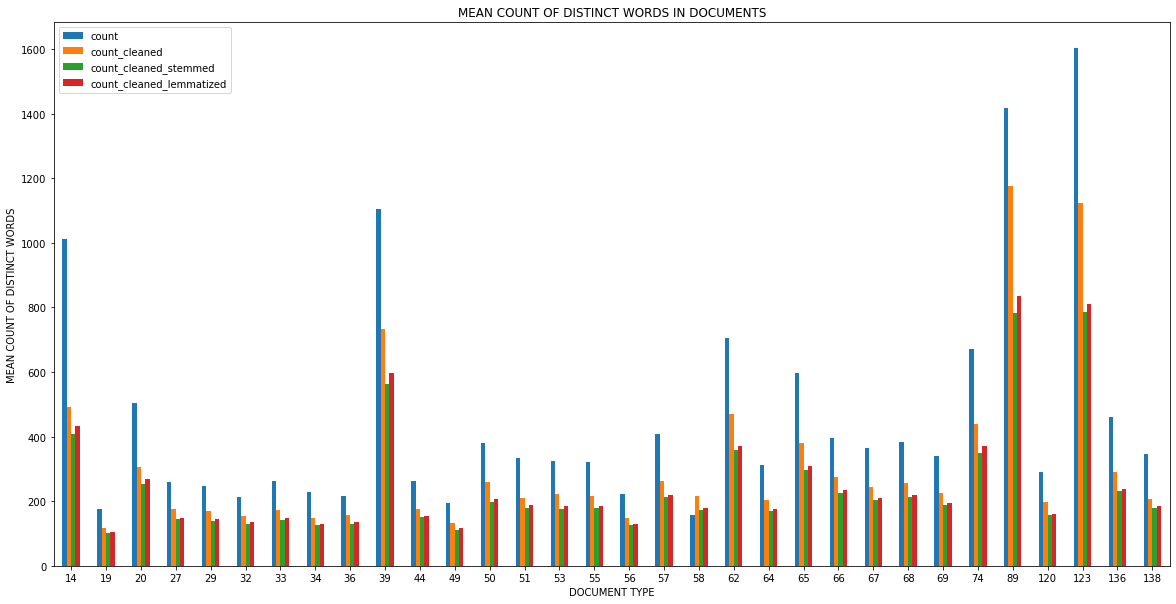

In [4]:
df = pd.DataFrame()
df = results4stats[0].join(results4stats[1], lsuffix='', rsuffix='_cleaned')
df['count_cleaned_stemmed'] = results4stats[2]['count']
df['count_cleaned_lemmatized'] = results4stats[3]['count']
ax = df.plot(kind='bar', figsize=(20,10), rot=0, title=f"MEAN COUNT OF DISTINCT WORDS IN DOCUMENTS", xlabel='DOCUMENT TYPE', ylabel='MEAN COUNT OF DISTINCT WORDS',)

# WORDCLOUD

In [3]:
def wordCloudFunction(column, numWords):
    topic_words = [item for sublist in [x.split() for x in column] for item in sublist]
    word_count_dict = Counter(topic_words)
    popular_words = sorted(word_count_dict, key = word_count_dict.get, reverse = True)
    word_string=' '.join(popular_words[:numWords])
    wordcloud = WordCloud(background_color='white', width=1000, height=1000, max_words=numWords).generate(word_string)
    plt.figure(figsize=(30,20) )
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

## Original

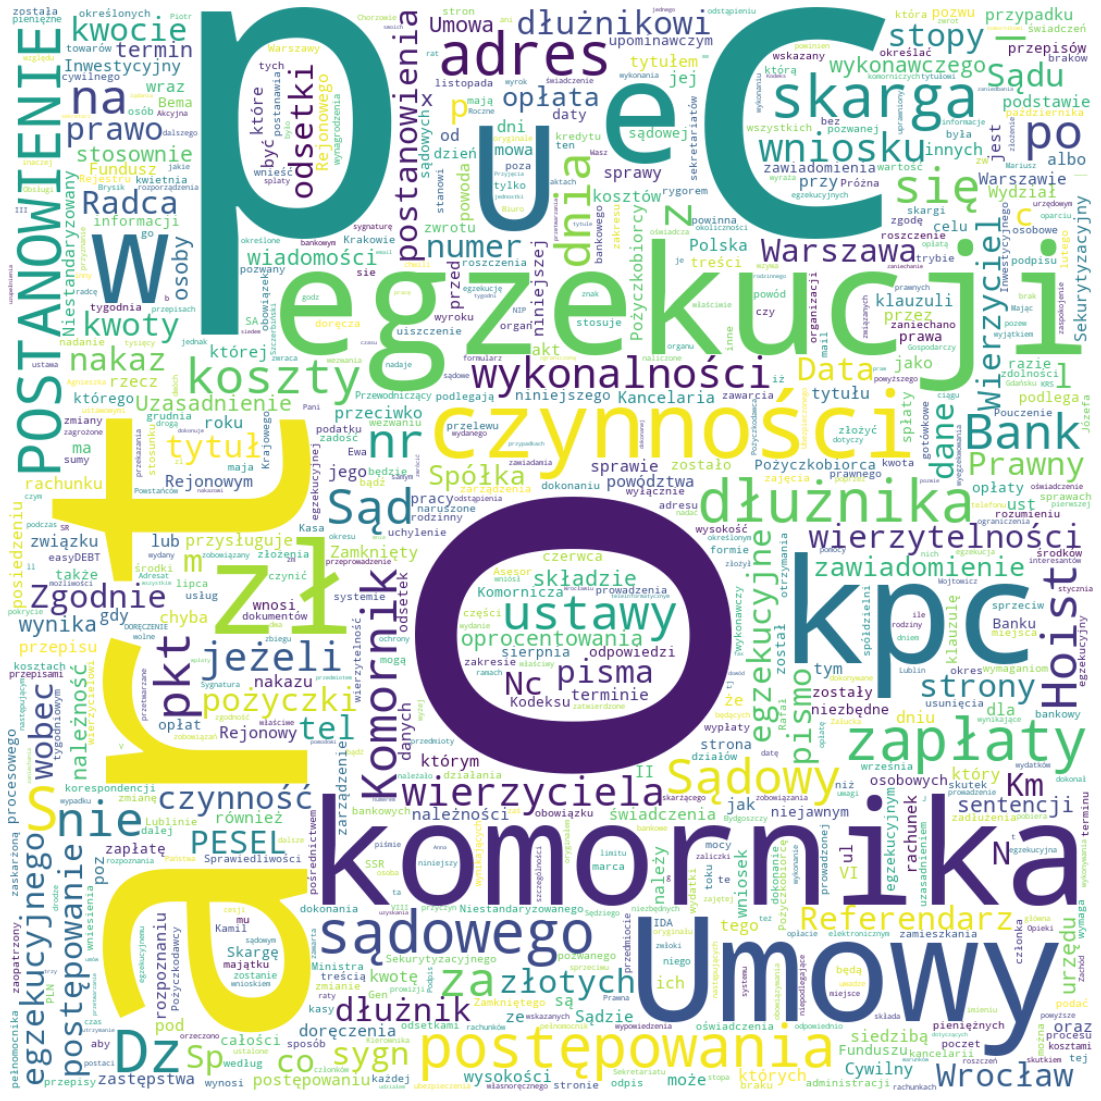

In [4]:
df = pd.read_csv(df_fpaths[0], sep=';')
df = limit_by_type(df, 1000, 'id_dokument', 'id_typ_dokument_true')
df['text'] = df['text'].astype('str')

wordCloudFunction(df['text'], 1000)

## Cleaned

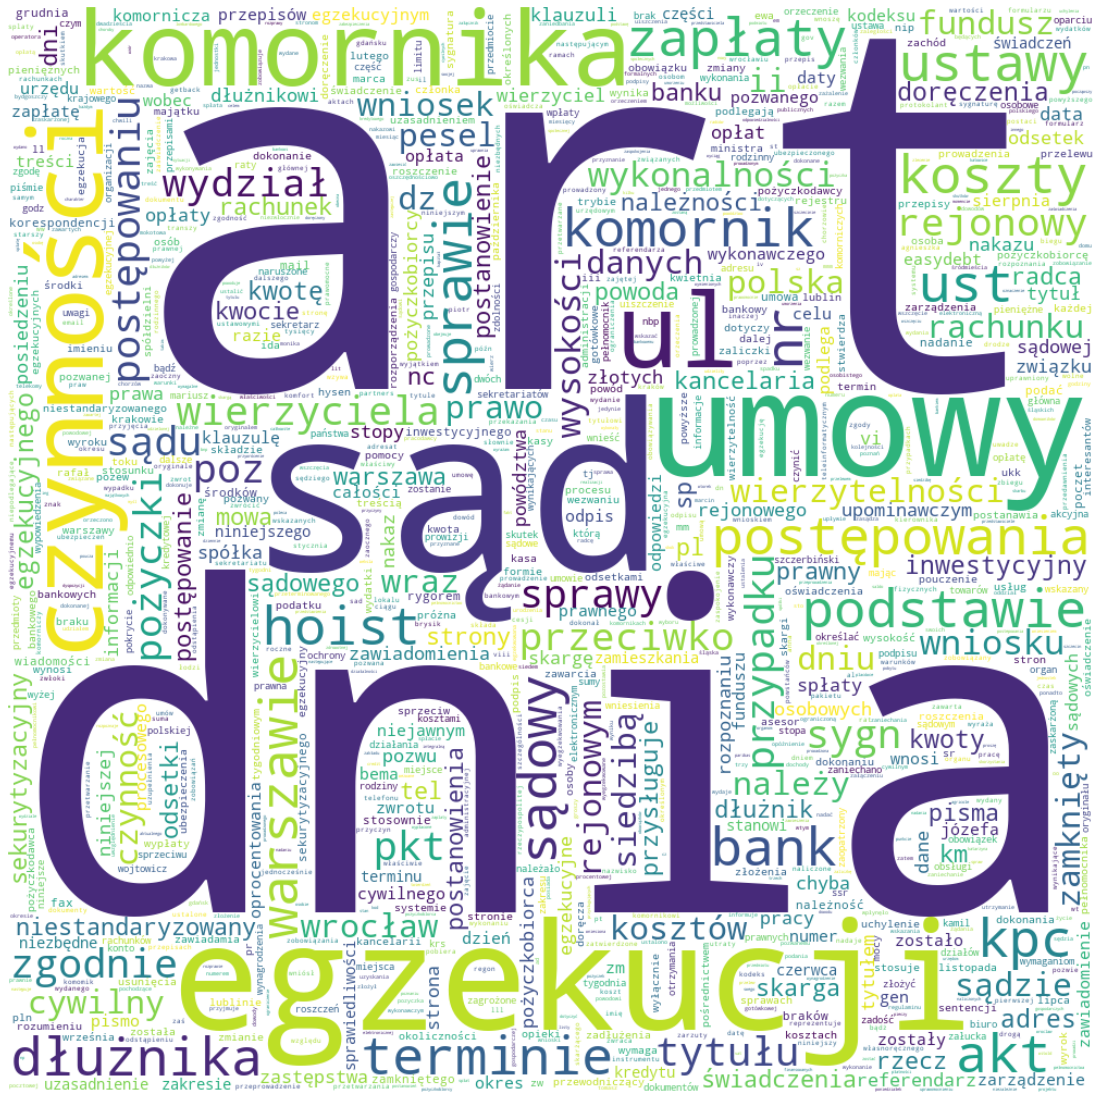

In [5]:
df = pd.read_csv(df_fpaths[1], sep=';')
df = limit_by_type(df, 1000, 'id', 'type')
df['text'] = df['text'].astype('str')

wordCloudFunction(df['text'], 1000)

## Cleaned & Stemmed

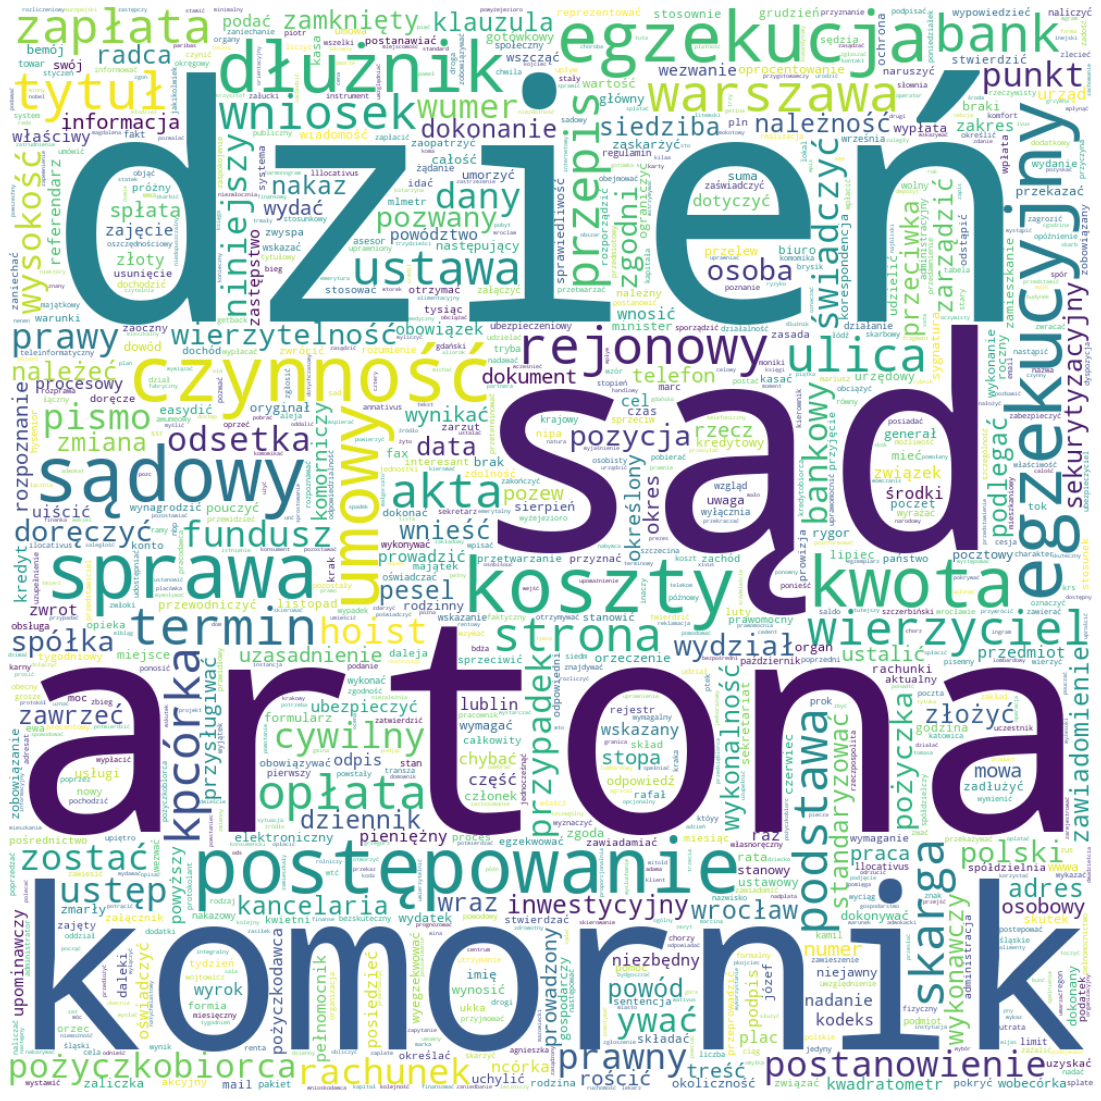

In [6]:
df = pd.read_csv(df_fpaths[2], sep=';')
df = limit_by_type(df, 1000, 'id', 'type')
df['text'] = df['text'].astype('str')

wordCloudFunction(df['text'], 1000)

## Cleaned & Lemmatized

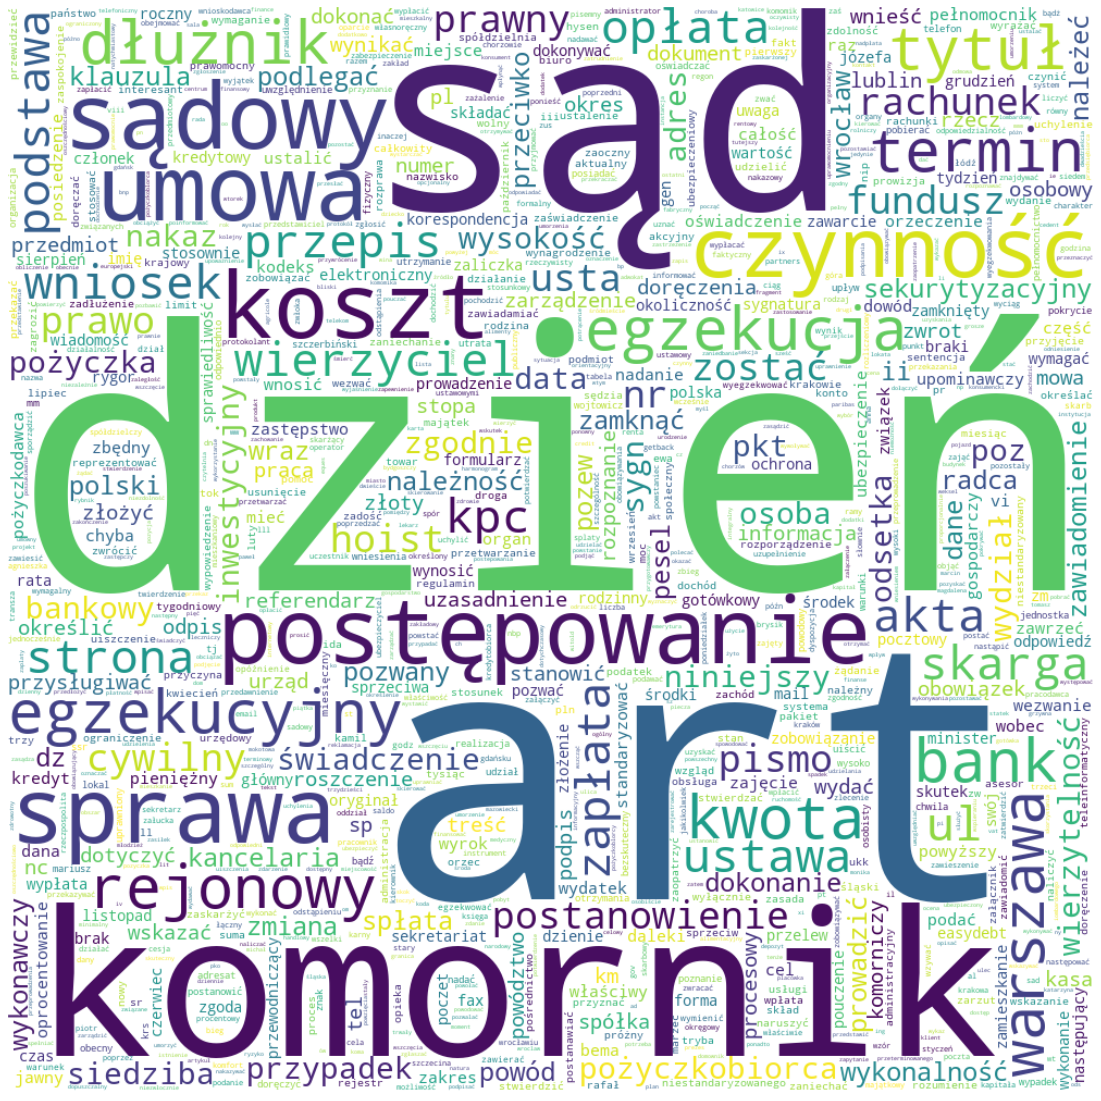

In [7]:
df = pd.read_csv(df_fpaths[3], sep=';')
df = limit_by_type(df, 1000, 'id', 'type')
df['text'] = df['text'].astype('str')

wordCloudFunction(df['text'], 1000)

# Stats

In [8]:
df = pd.read_csv(df_fpaths[0], sep=';')
id_type_cname = 'id_typ_dokument_true'

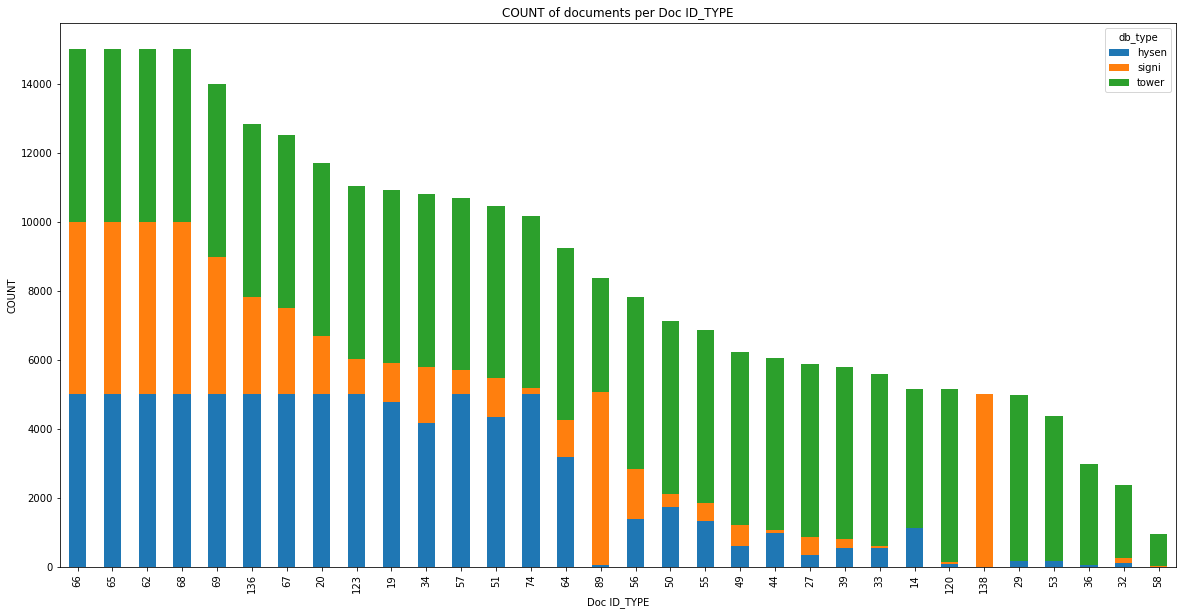

In [9]:
df_temp = df.groupby([id_type_cname, 'db_type']).size().unstack(fill_value=0)
df_temp['sum'] = df_temp.sum(axis = 1, skipna = True)
ax = df_temp.sort_values('sum', ascending=False)[set(df['db_type'])].plot(  kind='bar', 
                                                                            figsize=(20,10), 
                                                                            title=f"COUNT of documents per Doc ID_TYPE", 
                                                                            xlabel='Doc ID_TYPE',
                                                                            ylabel='COUNT',
                                                                            stacked=True)

In [10]:
df['year_month'] = pd.to_datetime(df['data_ins']).dt.to_period('M')

In [13]:
df_temp

db_type     hysen  signi  tower    sum
year_month                            
2020-10       464      0   1068   1532
2020-11      2663      0   1177   3840
2020-12      2158      0   1035   3193
2021-01      1222      0    916   2138
2021-02      3021      0   1403   4424
2021-03      1901      0   1550   3451
2021-04      1797      0   2685   4482
2021-05      2478      0   4882   7360
2021-06      2824      0   5895   8719
2021-07      4752   2441   6198  13391
2021-08      6671  12747   6606  26024
2021-09     12840  17271  13084  43195
2021-10     19103  19459  22017  60579

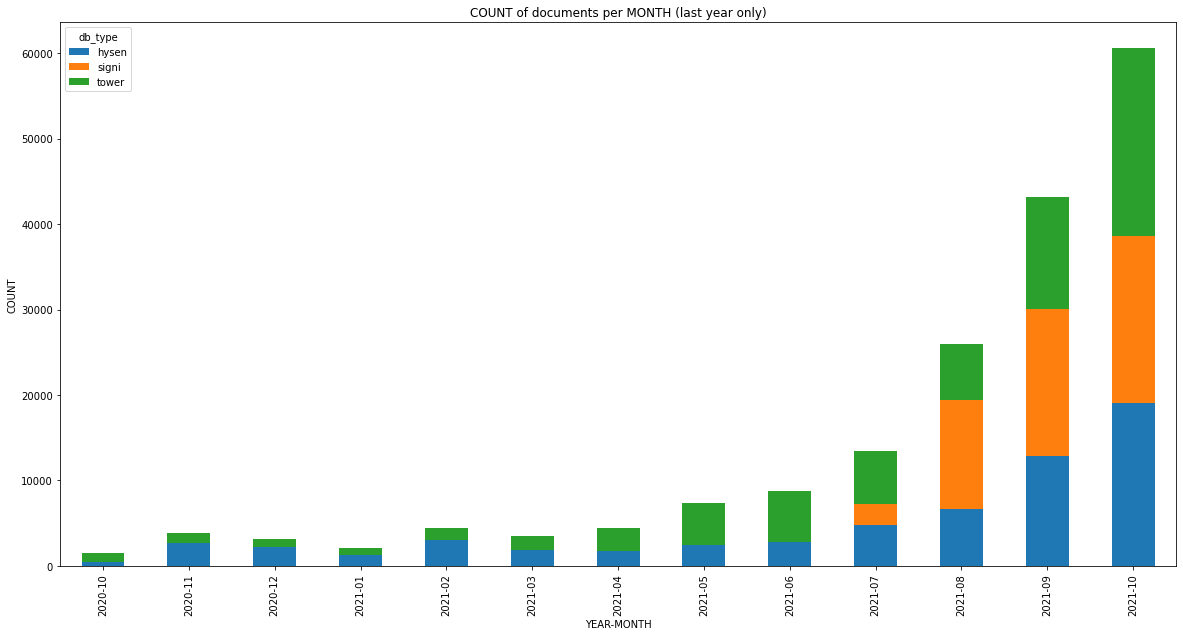

In [14]:
df_temp = df[df['year_month'] >= '2020-10']
df_temp = df_temp.groupby(['year_month', 'db_type']).size().unstack(fill_value=0)
df_temp['sum'] = df_temp.sum(axis = 1, skipna = True)
ax = df_temp.sort_values('year_month')[set(df['db_type'].tolist())].plot(  kind='bar', 
                                                                                figsize=(20,10), 
                                                                                title=f"COUNT of documents per MONTH (last year only)", 
                                                                                xlabel='YEAR-MONTH',
                                                                                ylabel='COUNT',
                                                                                stacked=True)

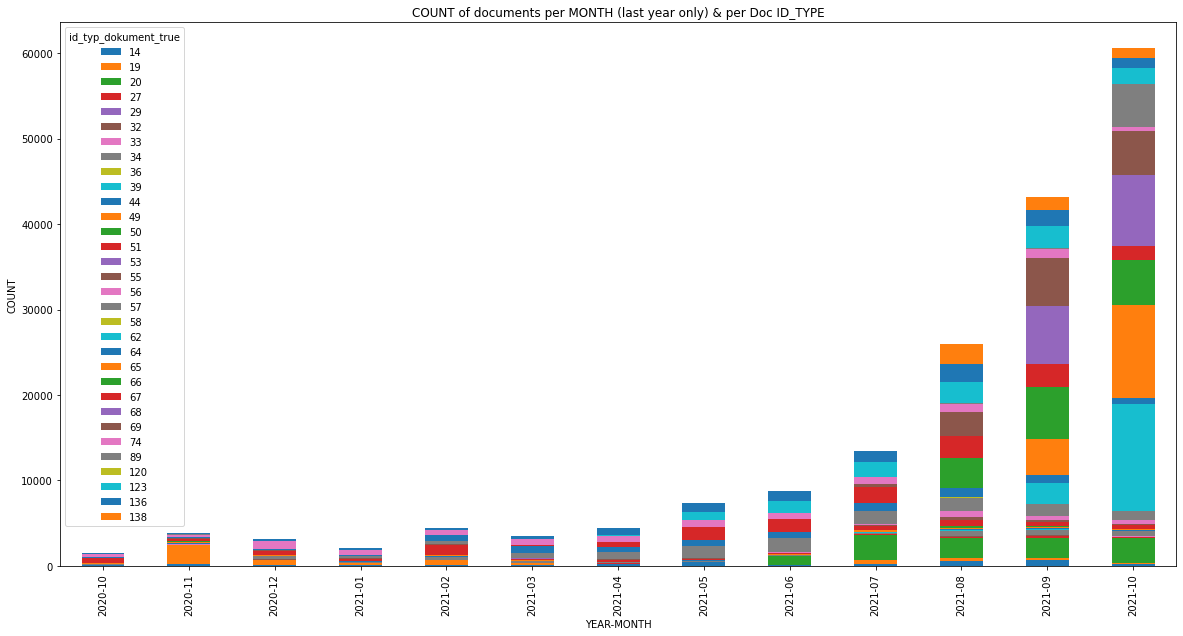

In [15]:
df_temp = df[df['year_month'] >= '2020-10']
df_temp = df_temp.groupby(['year_month', id_type_cname]).size().unstack(fill_value=0)
# df['sum'] = df.sum(axis = 1, skipna = True)
ax = df_temp.sort_values('year_month').plot(kind='bar', 
                                            figsize=(20,10), 
                                            title=f"COUNT of documents per MONTH (last year only) & per Doc ID_TYPE", 
                                            xlabel='YEAR-MONTH',
                                            ylabel='COUNT',
                                            stacked=True)

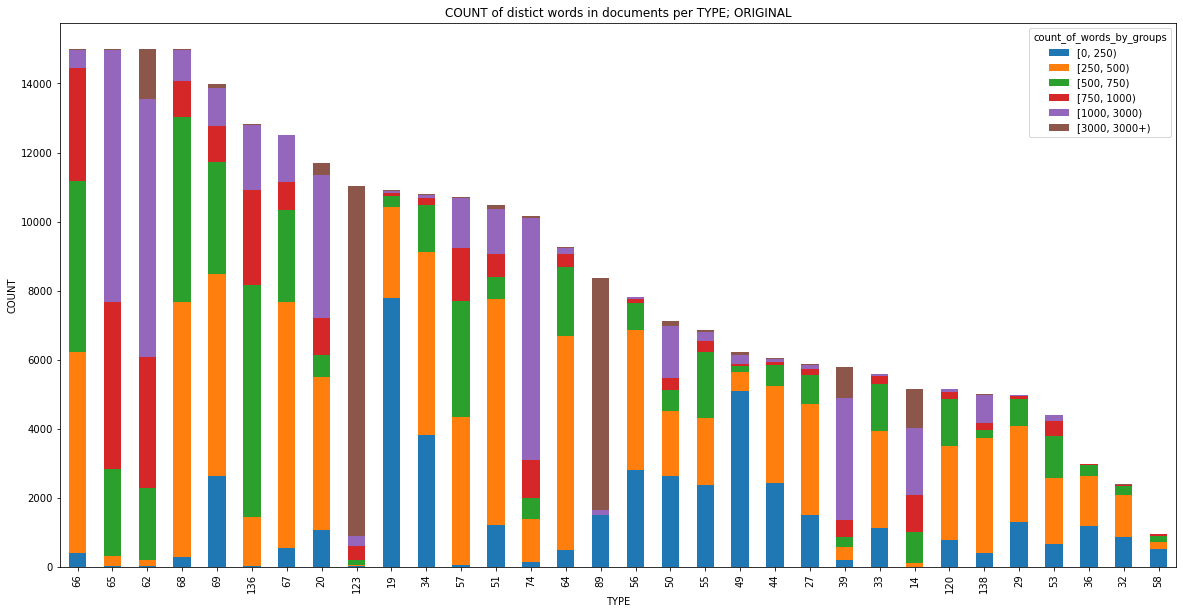

In [16]:
df = pd.read_csv(df_fpaths[0], sep=';')
df['text'] = df['text'].astype('str')

df['count_of_words'] = df['text'].apply(lambda x: len(x.split()))
df['count_of_words_by_groups'] = ''

df.loc[(df.count_of_words < 250), 'count_of_words_by_groups'] = '[0, 250)'
df.loc[(df.count_of_words >= 250) & (df.count_of_words < 500), 'count_of_words_by_groups'] = '[250, 500)'
df.loc[(df.count_of_words >= 500) & (df.count_of_words < 750), 'count_of_words_by_groups'] = '[500, 750)'
df.loc[(df.count_of_words >= 750) & (df.count_of_words < 1000), 'count_of_words_by_groups'] = '[750, 1000)'
df.loc[(df.count_of_words >= 1000) & (df.count_of_words < 3000), 'count_of_words_by_groups'] = '[1000, 3000)'
df.loc[(df.count_of_words >= 3000), 'count_of_words_by_groups'] = '[3000, 3000+)'

df_temp = df.groupby([id_type_cname, 'count_of_words_by_groups']).size().unstack(fill_value=0)
df_temp = df_temp[['[0, 250)', '[250, 500)', '[500, 750)', '[750, 1000)', '[1000, 3000)', '[3000, 3000+)']]
df_temp['sum'] = df_temp.sum(axis = 1, skipna = True)
ax = df_temp.sort_values('sum', ascending=False)[['[0, 250)', '[250, 500)', '[500, 750)', '[750, 1000)', '[1000, 3000)', '[3000, 3000+)']].plot(    kind='bar', 
                                                                        figsize=(20,10), 
                                                                        title=f"COUNT of distict words in documents per TYPE; ORIGINAL", 
                                                                        xlabel='TYPE',
                                                                        ylabel='COUNT',
                                                                        stacked=True)

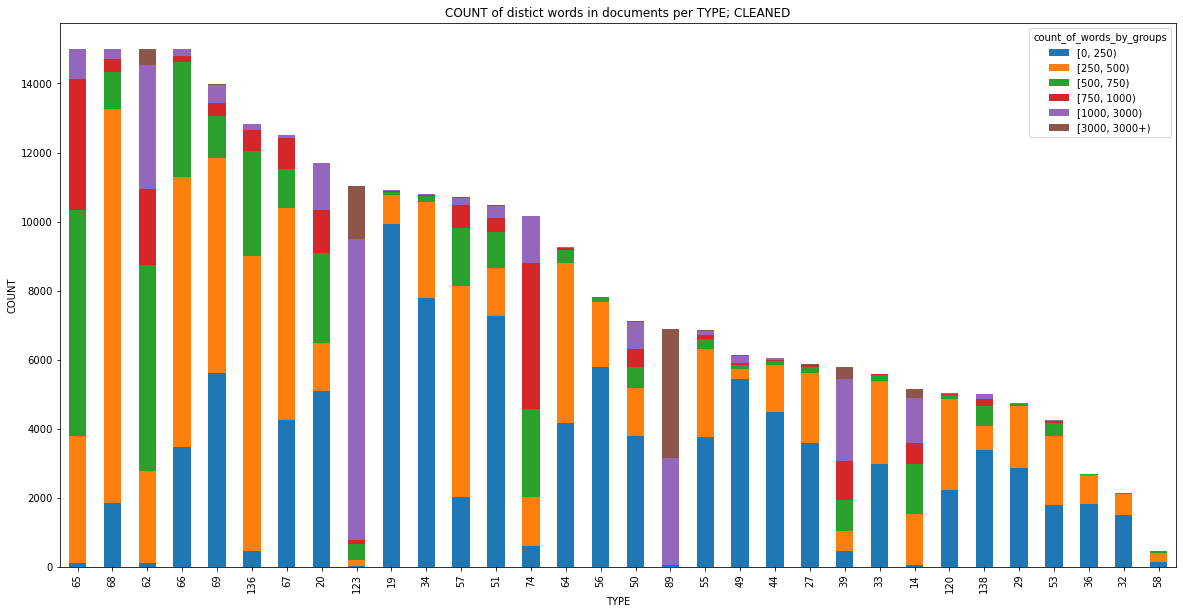

In [17]:
df = pd.read_csv(df_fpaths[1], sep=';')
df['text'] = df['text'].astype('str')

df['count_of_words'] = df['text'].apply(lambda x: len(x.split()))
df['count_of_words_by_groups'] = ''

df.loc[(df.count_of_words < 250), 'count_of_words_by_groups'] = '[0, 250)'
df.loc[(df.count_of_words >= 250) & (df.count_of_words < 500), 'count_of_words_by_groups'] = '[250, 500)'
df.loc[(df.count_of_words >= 500) & (df.count_of_words < 750), 'count_of_words_by_groups'] = '[500, 750)'
df.loc[(df.count_of_words >= 750) & (df.count_of_words < 1000), 'count_of_words_by_groups'] = '[750, 1000)'
df.loc[(df.count_of_words >= 1000) & (df.count_of_words < 3000), 'count_of_words_by_groups'] = '[1000, 3000)'
df.loc[(df.count_of_words >= 3000), 'count_of_words_by_groups'] = '[3000, 3000+)'

df_temp = df.groupby(['type', 'count_of_words_by_groups']).size().unstack(fill_value=0)
df_temp = df_temp[['[0, 250)', '[250, 500)', '[500, 750)', '[750, 1000)', '[1000, 3000)', '[3000, 3000+)']]
df_temp['sum'] = df_temp.sum(axis = 1, skipna = True)
ax = df_temp.sort_values('sum', ascending=False)[['[0, 250)', '[250, 500)', '[500, 750)', '[750, 1000)', '[1000, 3000)', '[3000, 3000+)']].plot(    kind='bar', 
                                                                        figsize=(20,10), 
                                                                        title=f"COUNT of distict words in documents per TYPE; CLEANED", 
                                                                        xlabel='TYPE',
                                                                        ylabel='COUNT',
                                                                        stacked=True)

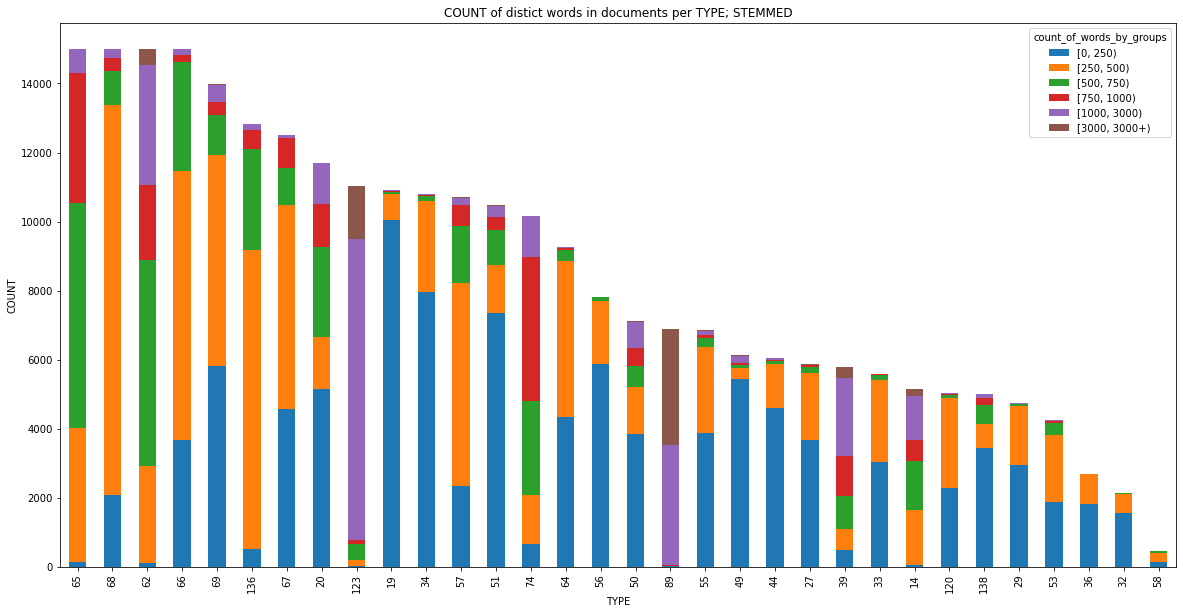

In [18]:
df = pd.read_csv(df_fpaths[2], sep=';')
df['text'] = df['text'].astype('str')

df['count_of_words'] = df['text'].apply(lambda x: len(x.split()))
df['count_of_words_by_groups'] = ''

df.loc[(df.count_of_words < 250), 'count_of_words_by_groups'] = '[0, 250)'
df.loc[(df.count_of_words >= 250) & (df.count_of_words < 500), 'count_of_words_by_groups'] = '[250, 500)'
df.loc[(df.count_of_words >= 500) & (df.count_of_words < 750), 'count_of_words_by_groups'] = '[500, 750)'
df.loc[(df.count_of_words >= 750) & (df.count_of_words < 1000), 'count_of_words_by_groups'] = '[750, 1000)'
df.loc[(df.count_of_words >= 1000) & (df.count_of_words < 3000), 'count_of_words_by_groups'] = '[1000, 3000)'
df.loc[(df.count_of_words >= 3000), 'count_of_words_by_groups'] = '[3000, 3000+)'

df_temp = df.groupby(['type', 'count_of_words_by_groups']).size().unstack(fill_value=0)
df_temp = df_temp[['[0, 250)', '[250, 500)', '[500, 750)', '[750, 1000)', '[1000, 3000)', '[3000, 3000+)']]
df_temp['sum'] = df_temp.sum(axis = 1, skipna = True)
ax = df_temp.sort_values('sum', ascending=False)[['[0, 250)', '[250, 500)', '[500, 750)', '[750, 1000)', '[1000, 3000)', '[3000, 3000+)']].plot(    kind='bar', 
                                                                        figsize=(20,10), 
                                                                        title=f"COUNT of distict words in documents per TYPE; STEMMED", 
                                                                        xlabel='TYPE',
                                                                        ylabel='COUNT',
                                                                        stacked=True)

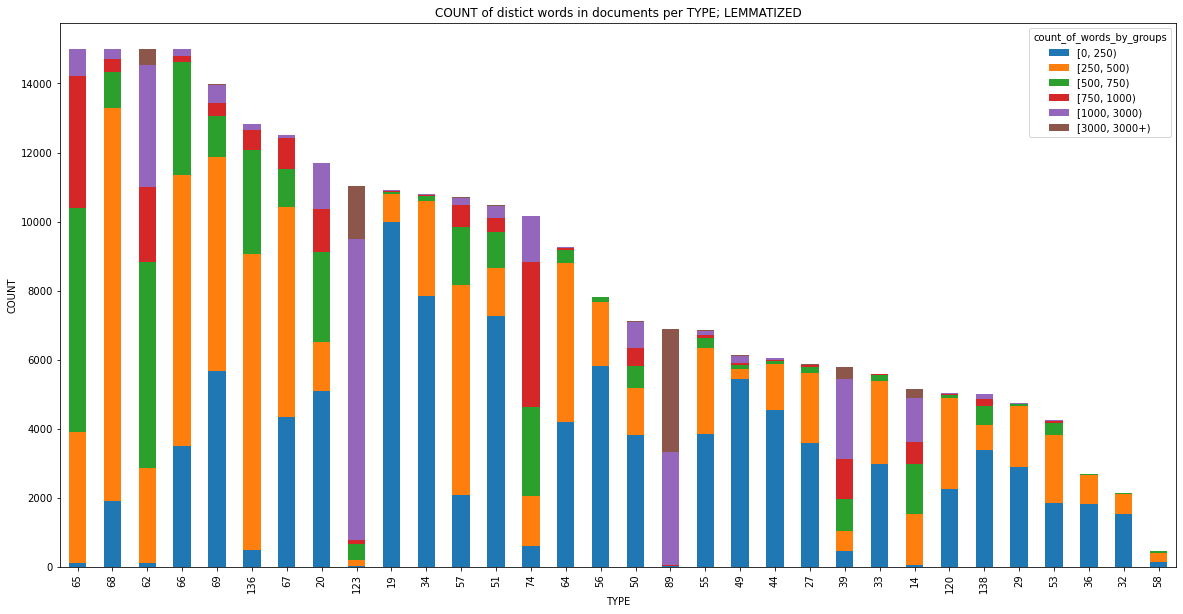

In [19]:
df = pd.read_csv(df_fpaths[3], sep=';')
df['text'] = df['text'].astype('str')

df['count_of_words'] = df['text'].apply(lambda x: len(x.split()))
df['count_of_words_by_groups'] = ''

df.loc[(df.count_of_words < 250), 'count_of_words_by_groups'] = '[0, 250)'
df.loc[(df.count_of_words >= 250) & (df.count_of_words < 500), 'count_of_words_by_groups'] = '[250, 500)'
df.loc[(df.count_of_words >= 500) & (df.count_of_words < 750), 'count_of_words_by_groups'] = '[500, 750)'
df.loc[(df.count_of_words >= 750) & (df.count_of_words < 1000), 'count_of_words_by_groups'] = '[750, 1000)'
df.loc[(df.count_of_words >= 1000) & (df.count_of_words < 3000), 'count_of_words_by_groups'] = '[1000, 3000)'
df.loc[(df.count_of_words >= 3000), 'count_of_words_by_groups'] = '[3000, 3000+)'

df_temp = df.groupby(['type', 'count_of_words_by_groups']).size().unstack(fill_value=0)
df_temp = df_temp[['[0, 250)', '[250, 500)', '[500, 750)', '[750, 1000)', '[1000, 3000)', '[3000, 3000+)']]
df_temp['sum'] = df_temp.sum(axis = 1, skipna = True)
ax = df_temp.sort_values('sum', ascending=False)[['[0, 250)', '[250, 500)', '[500, 750)', '[750, 1000)', '[1000, 3000)', '[3000, 3000+)']].plot(    kind='bar', 
                                                                        figsize=(20,10), 
                                                                        title=f"COUNT of distict words in documents per TYPE; LEMMATIZED", 
                                                                        xlabel='TYPE',
                                                                        ylabel='COUNT',
                                                                        stacked=True)

# Chosen types stats

In [23]:
df_chosen_types = pd.read_csv(f'{dset_path}/00_chosen_types/chosen_types_stats.csv', sep=';')
df_chosen_types.head()

id_typ_dokument                                               opis  \
0               14                        BTE z klauzulą wykonalności   
1               19            Nakaz zapłaty bez klauzuli wykonalności   
2               20              Nakaz zapłaty z klauzulą wykonalności   
3               27  Postanowienie o oddaleniu wniosku o nadanie kl...   
4               29                  Postanowienie o odrzuceniu pozwu    

   signi_t  signi_f  signi_acc  tower_t  tower_f  tower_acc  hysen_t  hysen_f  \
0        0        0   0.000000     4025      267   0.937791     1127       55   
1     1122        6   0.994681     5000       34   0.993246     4783        9   
2     1686        9   0.994690     5000        5   0.999001     5000        2   
3      521        1   0.998084     5000       54   0.989315      342        1   
4       14        0   1.000000     4803       16   0.996680      162       11   

   hysen_acc  
0   0.953469  
1   0.998122  
2   0.999600  
3   0.997085  
4   0.936416

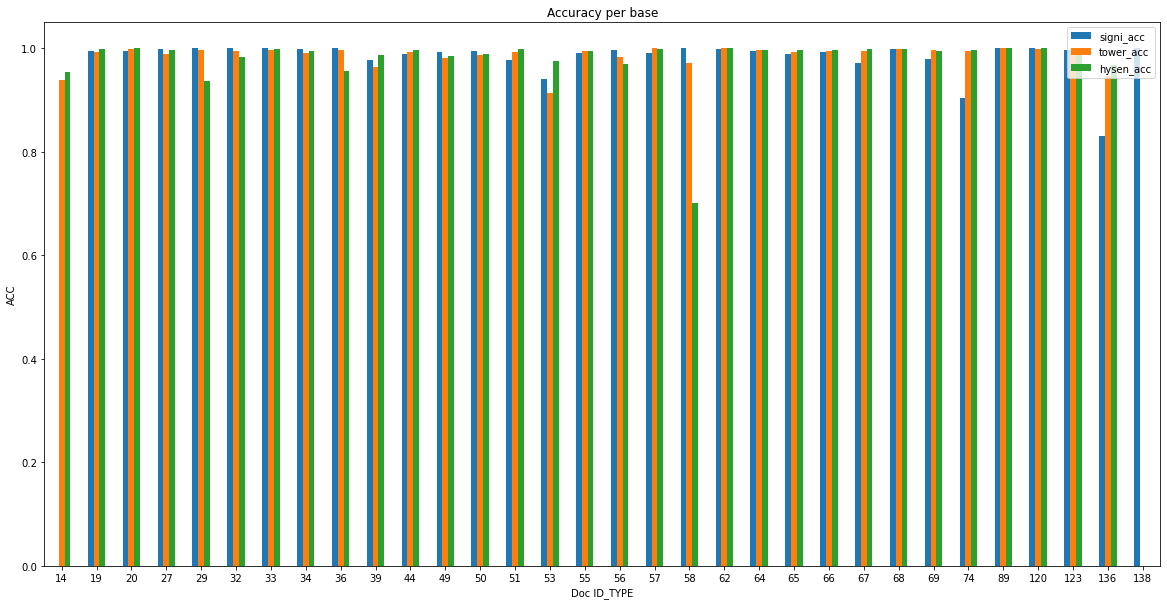

In [24]:
df = df_chosen_types[['id_typ_dokument', 'signi_acc', 'tower_acc', 'hysen_acc',]]
df = df.set_index('id_typ_dokument')

ax = df.sort_values('id_typ_dokument').plot(kind='bar', figsize=(20,10), rot=0, title=f"Accuracy per base", xlabel='Doc ID_TYPE', ylabel='ACC',)

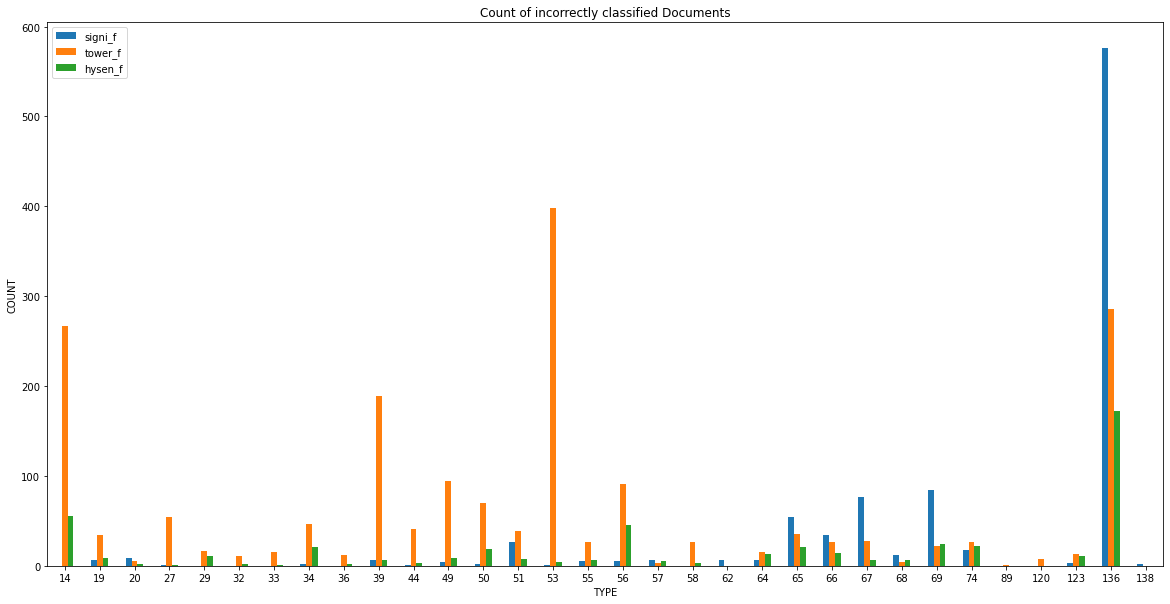

In [27]:
df = df_chosen_types[['id_typ_dokument', 'signi_f', 'tower_f', 'hysen_f',]]
df = df.set_index('id_typ_dokument')

ax = df.sort_values('id_typ_dokument').plot(kind='bar', figsize=(20,10), rot=0, title=f'Count of incorrectly classified Documents', xlabel='TYPE', ylabel='COUNT',)